In [1]:
import os
import math
import numpy as np
import pandas as pd
from ast import literal_eval
import pymc3
import itertools
import arviz as az
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
pd.options.mode.chained_assignment = None  # default='warn'

from helper_functions import *

### Color choice:

For 2 colors that are easily distinguishable for people with various color blindness, red and blue seems to be the best set. We will go with **#F05039** and **#1F449C** as saturated colors. **#EEBAB4** and **#7CA1CC** will be our less saturated red and blue.

# Fixations

In [64]:
eye_data = pd.read_csv("eye_data/situational_analysis_data/situational_fixations_data.csv", index_col=False)
eye_data

,Unnamed: 0,code,level,drift,input_noise,trial,success,timeTag,exploring_fixation,fixation_duration,distSpaceship_fix_rest,distClosestObstacle_fix_explore,distSpaceship_fix_rest_in_pixel,distClosestObstacle_fix_explore_in_pixel
0,0,OK01UE,2,F,W,8,False,29.3670,False,0.1350,1.712461,NaN,81.038419,NaN
1,1,OK01UE,2,F,W,8,False,29.5410,True,0.3400,NaN,7.608570,NaN,362.082343
2,2,OK01UE,2,F,W,8,False,29.9260,False,0.3640,0.837370,NaN,39.617676,NaN
3,3,OK01UE,2,F,W,8,False,30.3275,True,0.2915,NaN,4.747514,NaN,225.114107
4,4,OK01UE,2,F,W,8,False,30.6505,False,0.4870,1.797914,NaN,85.084884,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2653,2653,UD06AD,6,T,W,34,True,12.4205,False,0.2660,2.273812,NaN,107.627591,NaN
2654,2654,UD06AD,6,T,W,34,True,12.7330,True,0.5345,NaN,7.402418,NaN,352.160281
2655,2655,UD06AD,6,T,W,34,True,13.3095,True,0.1825,NaN,9.901394,NaN,473.141327
2656,2656,UD06AD,6,T,W,34,True,13.5110,True,0.1615,NaN,9.206672,NaN,439.343424


## Plotting fixation duration with gamma coefficients

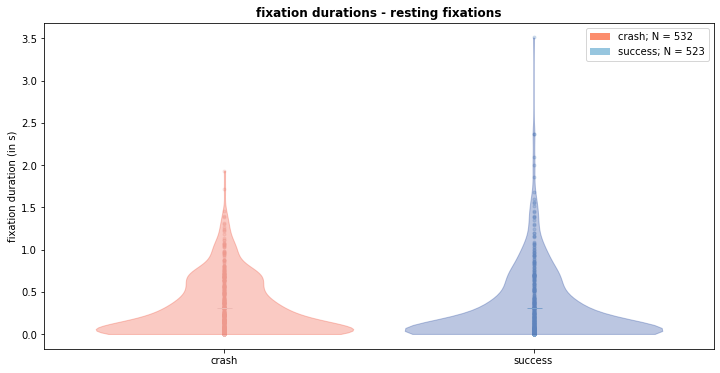

In [45]:
#def plot_fixation_duration(eye_data, target_fixations="rest", log_scale=False, safe_plot=False,
#                           path_to_save_folder=f"{os.getcwd()}/plots/plots_fixation_duration/"):

eye_data = pd.read_csv("eye_data/situational_analysis_data/situational_fixations_data.csv", index_col=False)
target_fixations = "rest"
dist="gauss"
crash_intercept = np.nan
success_intercept = np.nan
significance = False
safe_plot=False
path_to_save_folder=f"{os.getcwd()}/plots/plot_fixation_duration_crash_vs_success/"

"""
:param eye_data: data must contain column for target fixations as well as success column (True vs. False)
:param target_fixations: "rest" vs. "explore"
:param dist: distribution of predicted variable
:param crash_intercept: intercept in linear model - used to draw regression line
:param success_intercept: intercept in linear model - used to draw regression line
:param significance: whether comparison in linear model is significant or not
:param safe_plot: True vs. False - determines whether plots are saved or not
:param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
"""

if target_fixations == "rest":
    fixation_type = "resting fixations"
    eye_data = eye_data[eye_data.exploring_fixation == False]
elif target_fixations == "explore":
    fixation_type = "exploring fixations"
    eye_data = eye_data[eye_data.exploring_fixation == True]

fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title(f"Fixation durations - {fixation_type}", fontdict={"fontweight": "bold"})

# axis labels
ax.set_xlabel("")
ax.set_ylabel("fixation duration (in s)")

ax.set_xlim([-0.65, 0.65])
ax.set_xticks([-0.3, 0.3])
ax.set_xticklabels(["crash", "success"])

# Plotting
colors = ["#F05039", "#1F449C"]
colors_p = ["#EEBAB4", "#7CA1CC"]
color_maps = ["Reds", "Greens", "Blues"]
ticks = ["crash", "success"]
offset = [-0.3, 0.3]

n_target_fixations = [np.nan, np.nan]
mean_target_fixations = [np.nan, np.nan]

counter = 0

# subsetting data for individual plotting
eye_data_crash = eye_data[eye_data.success == False]
eye_data_success = eye_data[eye_data.success == True]

for eye_data in [eye_data_crash, eye_data_success]:
    
    plot_labels = [offset[counter]] * eye_data.fixation_duration.count()
    eye_data["plot_label"] = [offset[counter]] * eye_data.fixation_duration.count()
    
    mean_target_fixations[counter] = np.mean(eye_data.fixation_duration)
    n_target_fixations[counter] = eye_data.fixation_duration.count()

    # draw on canvas
    ax.scatter(eye_data.plot_label, eye_data.fixation_duration, marker=".", color=colors_p[counter],
               alpha=0.3)
    ax.plot(offset[counter], np.mean(eye_data.fixation_duration), marker="_", markersize=15,
            color=colors_p[counter], alpha=1.0)

    # display density in violinplot over points
    violin = ax.violinplot(eye_data.fixation_duration, showextrema=False, positions=[offset[counter]])
    violinparts = violin['bodies']
    for vp in violinparts:
        vp.set_facecolor(colors[counter])
        vp.set_edgecolor(colors[counter])

    counter += 1
    
# add regression line
if not (np.isnan(crash_intercept) & np.isnan(success_intercept)):
    x_values = [offset[0], offset[1]]
    y_values = [crash_intercept, success_intercept]
    plt.plot(x_values, y_values, 'o', linestyle="-", color="black")
    label_y = crash_intercept+(success_intercept-crash_intercept)/2
    if significance:
        plt.text(0, label_y, "*")

handles = [mpatches.Patch(facecolor=plt.cm.Reds(100),
                          label=f"{ticks[0]}; N = {n_target_fixations[0]}"),
           mpatches.Patch(facecolor=plt.cm.Blues(100),
                          label=f"{ticks[1]}; N = {n_target_fixations[1]}")]
ax.legend(handles=handles)

#if safe_plot:
#    plt.savefig(
#        f"{path_to_save_folder}fixation_duration_{fixation_type}_crash_vs_success",
#        dpi=300)
#    plt.close()

## Plotting distance to X

In [70]:
def plot_distance_to_(eye_data, 
                      target_fixations="rest", 
                      dist="gauss", 
                      crash_intercept=np.nan,
                      success_intercept=np.nan, 
                      significance=False, 
                      safe_plot=False, 
                      path_to_save_folder=f"{os.getcwd()}/plots/plots_fixation_duration/"):


    """
    :param eye_data: data must contain column for target fixations as well as success column (True vs. False)
    :param target_fixations: "rest" vs. "explore"
    :param dist: distribution of predicted variable
    :param crash_intercept: intercept in linear model - used to draw regression line
    :param success_intercept: intercept in linear model - used to draw regression line
    :param significance: whether comparison in linear model is significant or not
    :param safe_plot: True vs. False - determines whether plots are saved or not
    :param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
    """

    if target_fixations == "rest":
        fixation_type = "resting fixations"
        eye_data = eye_data[eye_data.exploring_fixation == False]
        target_col = "distSpaceship_fix_rest"
        title_string = "Distance to spaceship"
    elif target_fixations == "explore":
        fixation_type = "exploring fixations"
        eye_data = eye_data[eye_data.exploring_fixation == True]
        target_col = "distClosestObstacle_fix_explore"
        title_string = "Distance to closest obstacle"
        

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.set_title(f"{title_string} - {fixation_type}", fontdict={"fontweight": "bold"})

    # axis labels
    ax.set_xlabel("")
    ax.set_ylabel(f"{title_string} (in °)")

    ax.set_xlim([-0.65, 0.65])
    ax.set_xticks([-0.3, 0.3])
    ax.set_xticklabels(["crash", "success"])

    # Plotting
    colors = ["#F05039", "#1F449C"]
    colors_p = ["#EEBAB4", "#7CA1CC"]
    color_maps = ["Reds", "Greens", "Blues"]
    ticks = ["crash", "success"]
    offset = [-0.3, 0.3]

    n_target_fixations = [np.nan, np.nan]
    mean_target_fixations = [np.nan, np.nan]

    counter = 0

    # subsetting data for individual plotting
    eye_data_crash = eye_data[eye_data.success == False]
    eye_data_success = eye_data[eye_data.success == True]

    for eye_data in [eye_data_crash, eye_data_success]:

        plot_labels = [offset[counter]] * eye_data[target_col].count()
        eye_data["plot_label"] = [offset[counter]] * eye_data[target_col].count()

        mean_target_fixations[counter] = np.mean(eye_data[target_col])
        n_target_fixations[counter] = eye_data[target_col].count()

        # draw on canvas
        ax.scatter(eye_data.plot_label, eye_data[target_col], marker=".", color=colors_p[counter],
                   alpha=0.3)
        ax.plot(offset[counter], np.mean(eye_data[target_col]), marker="_", markersize=15,
                color=colors_p[counter], alpha=1.0)

        # display density in violinplot over points
        violin = ax.violinplot(eye_data[target_col], showextrema=False, positions=[offset[counter]])
        violinparts = violin['bodies']
        for vp in violinparts:
            vp.set_facecolor(colors[counter])
            vp.set_edgecolor(colors[counter])

        counter += 1

    # add regression line
    if not (np.isnan(crash_intercept) & np.isnan(success_intercept)):
        x_values = [offset[0], offset[1]]
        y_values = [crash_intercept, success_intercept]
        plt.plot(x_values, y_values, 'o', linestyle="-", color="black")
        label_y = crash_intercept+(success_intercept-crash_intercept)/2
        if significance:
            plt.text(0, label_y, "*")

    handles = [mpatches.Patch(facecolor=plt.cm.Reds(100),
                              label=f"{ticks[0]}; N = {n_target_fixations[0]}"),
               mpatches.Patch(facecolor=plt.cm.Blues(100),
                              label=f"{ticks[1]}; N = {n_target_fixations[1]}")]
    ax.legend(handles=handles)

    if safe_plot:
        plt.savefig(
            f"{path_to_save_folder}{target_col_}{fixation_type}_crash_vs_success",
            dpi=300)
        plt.close()

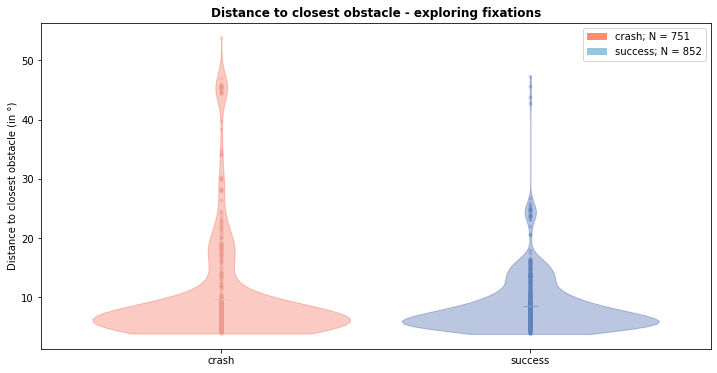

In [65]:
eye_data = pd.read_csv("eye_data/situational_analysis_data/situational_fixations_data.csv", index_col=False)

plot_distance_to_(eye_data, target_fixations="explore", dist="gauss", crash_intercept=np.nan, 
                  success_intercept=np.nan, significance=False, safe_plot=False, 
                  path_to_save_folder=f"{os.getcwd()}/plots/plot_distance_to_x_crash_vs_success/")

In [66]:

#eye_data = pd.read_csv("eye_data/situational_analysis_data/situational_fixations_data.csv", index_col=False)

#eye_data["distSpaceship_fix_rest_in_pixel"] = eye_data.distSpaceship_fix_rest
#eye_data.distSpaceship_fix_rest = eye_data.apply(lambda x: pixel_to_degree(x.distSpaceship_fix_rest), axis=1)

#eye_data["distClosestObstacle_fix_explore_in_pixel"] = eye_data.distClosestObstacle_fix_explore
#eye_data.distClosestObstacle_fix_explore = eye_data.apply(lambda x: pixel_to_degree(x.distClosestObstacle_fix_explore), axis=1)

#eye_data.to_csv('eye_data/situational_analysis_data/situational_fixations_data.csv', sep=',')


# Saccades

In [67]:
eye_data = pd.read_csv("eye_data/situational_analysis_data/situational_saccades_data.csv", index_col=False)
eye_data

,code,level,drift,input_noise,trial,success,timeTag,progressive_saccade,saccade_amplitude,distClosestObstacle_sacc_progress,distClosestObstacle_sacc_regress
0,OK01UE,2,F,W,8,False,29.5115,True,2.836661,7.494577,NaN
1,OK01UE,2,F,W,8,False,29.8935,False,1.660988,NaN,1.048465
2,OK01UE,2,F,W,8,False,30.3005,True,1.450202,2.720191,NaN
3,OK01UE,2,F,W,18,True,28.7020,False,0.575024,NaN,1.502376
4,OK01UE,2,F,W,18,True,29.1720,True,2.292243,3.231453,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1046,UD06AD,5,F,S,49,True,19.4980,True,5.950997,0.998869,NaN
1047,UD06AD,6,T,W,30,False,12.8290,True,3.803168,2.642128,NaN
1048,UD06AD,6,T,W,30,False,13.2090,True,2.256818,2.079489,NaN
1049,UD06AD,6,T,W,34,True,12.6985,True,1.839191,3.631295,NaN


## Plotting saccade amplitude

In [72]:
def plot_saccade_amplitude(eye_data, 
                           target_saccades = "progress", 
                           dist="gauss",
                           crash_intercept = np.nan,
                           success_intercept = np.nan,
                           significance = False,
                           safe_plot=False, 
                           path_to_save_folder=f"{os.getcwd()}/plots/plots_saccade_amplitude/"):


    """
    :param eye_data: data must contain column for target saccades as well as success column (True vs. False)
    :param target_saccades: "progress" vs. "regress"
    :param dist: distribution of predicted variable
    :param crash_intercept: intercept in linear model - used to draw regression line
    :param success_intercept: intercept in linear model - used to draw regression line
    :param significance: whether comparison in linear model is significant or not
    :param safe_plot: True vs. False - determines whether plots are saved or not
    :param path_to_save_folder: path to the folder in which plots are saved in case of safe_plot=True
    """

    if target_saccades == "progress":
        saccade_type = "progressive saccades"
        eye_data = eye_data[eye_data.progressive_saccade == True]
    elif target_saccades == "regress":
        saccade_type = "regressive saccades"
        eye_data = eye_data[eye_data.progressive_saccade == False]

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.set_title(f"Saccade amplitudes - {saccade_type}", fontdict={"fontweight": "bold"})

    # axis labels
    ax.set_xlabel("")
    ax.set_ylabel("saccade amplitude (in °)")

    ax.set_xlim([-0.65, 0.65])
    ax.set_xticks([-0.3, 0.3])
    ax.set_xticklabels(["crash", "success"])

    # Plotting
    colors = ["#F05039", "#1F449C"]
    colors_p = ["#EEBAB4", "#7CA1CC"]
    color_maps = ["Reds", "Greens", "Blues"]
    ticks = ["crash", "success"]
    offset = [-0.3, 0.3]

    n_target_saccades = [np.nan, np.nan]
    mean_target_saccades = [np.nan, np.nan]

    counter = 0

    # subsetting data for individual plotting
    eye_data_crash = eye_data[eye_data.success == False]
    eye_data_success = eye_data[eye_data.success == True]

    for eye_data in [eye_data_crash, eye_data_success]:

        plot_labels = [offset[counter]] * eye_data.saccade_amplitude.count()
        eye_data["plot_label"] = [offset[counter]] * eye_data.saccade_amplitude.count()

        mean_target_fixations[counter] = np.mean(eye_data.saccade_amplitude)
        n_target_fixations[counter] = eye_data.saccade_amplitude.count()

        # draw on canvas
        ax.scatter(eye_data.plot_label, eye_data.saccade_amplitude, marker=".", color=colors_p[counter],
                   alpha=0.3)
        ax.plot(offset[counter], np.mean(eye_data.saccade_amplitude), marker="_", markersize=15,
                color=colors_p[counter], alpha=1.0)

        # display density in violinplot over points
        violin = ax.violinplot(eye_data.saccade_amplitude, showextrema=False, positions=[offset[counter]])
        violinparts = violin['bodies']
        for vp in violinparts:
            vp.set_facecolor(colors[counter])
            vp.set_edgecolor(colors[counter])

        counter += 1

    # add regression line
    if not (np.isnan(crash_intercept) & np.isnan(success_intercept)):
        x_values = [offset[0], offset[1]]
        y_values = [crash_intercept, success_intercept]
        plt.plot(x_values, y_values, 'o', linestyle="-", color="black")
        label_y = crash_intercept+(success_intercept-crash_intercept)/2
        if significance:
            plt.text(0, label_y, "*")

    handles = [mpatches.Patch(facecolor=plt.cm.Reds(100),
                              label=f"{ticks[0]}; N = {n_target_saccades[0]}"),
               mpatches.Patch(facecolor=plt.cm.Blues(100),
                              label=f"{ticks[1]}; N = {n_target_saccades[1]}")]
    ax.legend(handles=handles)

    if safe_plot:
        plt.savefig(
            f"{path_to_save_folder}saccade_amplitude_{saccade_type}_crash_vs_success",
            dpi=300)
        plt.close()

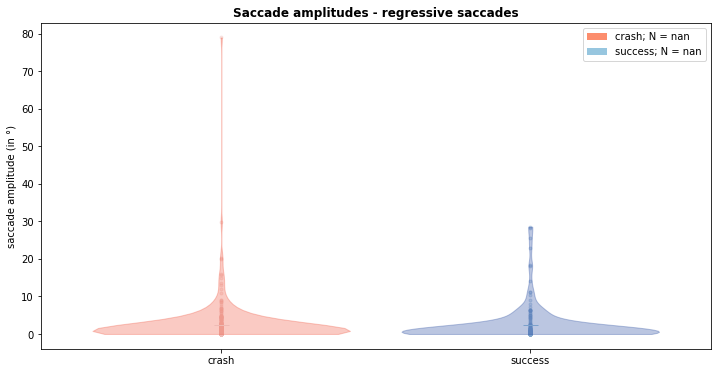

In [73]:
eye_data = pd.read_csv("eye_data/situational_analysis_data/situational_saccades_data.csv", index_col=False)

plot_saccade_amplitude(eye_data=eye_data, target_saccades="regress")